In [44]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pytidycensus as tc
import networkx as nx
from sklearn.cluster import KMeans

In [45]:
pd.set_option("display.max_columns", None)

In [46]:
tc.set_census_api_key("3d33dd56fa8e81fd42e039aadf43b9676976f27c")

variables = {
    "B01003_001E": "total_population",              
    "B01002_001E": "median_age",                    
    "B02001_002E": "white",                
    "B02001_003E": "black",  
    "B02001_004E" : "native",
    "B02001_005E" : "asian",
    "B02001_006E" : "pacific_islander",
    "B02001_007E" : "other",
    "B02001_008E" : "two_or_more_races",
    "B05001_006E" : "not_citizen",
    "B06001_013E": "born_in_nc",
    "B06001_037E": "born_outside_us",
    "B06007_005E": "english_less_than_well", 
    "B07001_001E": "geographically_mobile",
    "B07001_065E": "moved_from_diff_state",    #past year
    "B07001_081E": "moved_from_abroad",
    "B03003_003E": "hispanic",             
    "B19013_001E": "median_household_income",      
    "B15003_022E": "bachelors_degree",

    "B08301_002E": "drove_alone",
    "B08301_003E": "carpooled",
    "B08301_010E": "public_transit",
    "B08301_011E": "walked",
    "B08301_012E": "other_means",
    "B08301_013E": "worked_from_home",

    # Travel time to work
    "B08303_002E": "commute_less_5",
    "B08303_003E": "commute_5_to_9",
    "B08303_004E": "commute_10_to_14",
    "B08303_005E": "commute_15_to_19",
    "B08303_006E": "commute_20_to_24",
    "B08303_007E": "commute_25_to_29",
    "B08303_008E": "commute_30_to_34",
    "B08303_009E": "commute_35_to_39",
    "B08303_010E": "commute_40_to_44",
    "B08303_011E": "commute_45_to_59",
    "B08303_012E": "commute_60_or_more",

    "B25064_001E" : "median_gross_rent",

    "B19001_001E": "total_households",
    "B19001_002E": "income_less_than_10k",
    "B19001_003E": "income_10k_to_14_9k",
    "B19001_004E": "income_15k_to_19_9k",
    "B19001_005E": "income_20k_to_24_9k",
    "B19001_006E": "income_25k_to_29_9k",
    "B19001_007E": "income_30k_to_34_9k",
    "B19001_008E": "income_35k_to_39_9k",
    "B19001_009E": "income_40k_to_44_9k",
    "B19001_010E": "income_45k_to_49_9k",
    "B19001_011E": "income_50k_to_59_9k",
    "B19001_012E": "income_60k_to_74_9k",
    "B19001_013E": "income_75k_to_99_9k",
    "B19001_014E": "income_100k_to_124_9k",
    "B19001_015E": "income_125k_to_149_9k",
    "B19001_016E": "income_150k_to_199_9k",
    "B19001_017E": "income_200k_or_more"
    
}

year = 2023
gdf = tc.get_acs(
    geography="county",
    variables=list(variables.keys()),
    state="NC",
    year=year,
    output="wide",    
    geometry=True  
)

#drop columns for margin of error (only keep estimate)
moe_cols = [col for col in gdf.columns if col.endswith("e")]
gdf = gdf.drop(columns = moe_cols)


#rename columns from variable key to statistic
gdf = gdf.rename(columns={var: name for var, name in variables.items()})

Census API key has been set for this session.
Getting data from the 2019-2023 5-year ACS
Large table request: 108 variables will be retrieved in chunks


In [47]:
gdf = gdf.drop(columns=['NAME', 'GEOID', 'county'])

cols = [c for c in gdf.columns if c != 'geometry'] + ['geometry']
gdf = gdf.loc[:, cols]

In [89]:
np.pi

3.141592653589793

In [90]:
#cosine similarity to get edge weights
def similarity(co1, co2):
    c1 = np.array(gdf[gdf['NAMELSAD'] == co1].iloc[:,2:-1])  #don't need first 2 observations (county name and population)
    c2 = np.array(gdf[gdf['NAMELSAD'] == co2].iloc[:,2:-1]).T
    return 1 - 2 * np.arccos(np.dot(c1,c2)/(np.linalg.norm(c1) * np.linalg.norm(c2)))[0,0]/np.pi

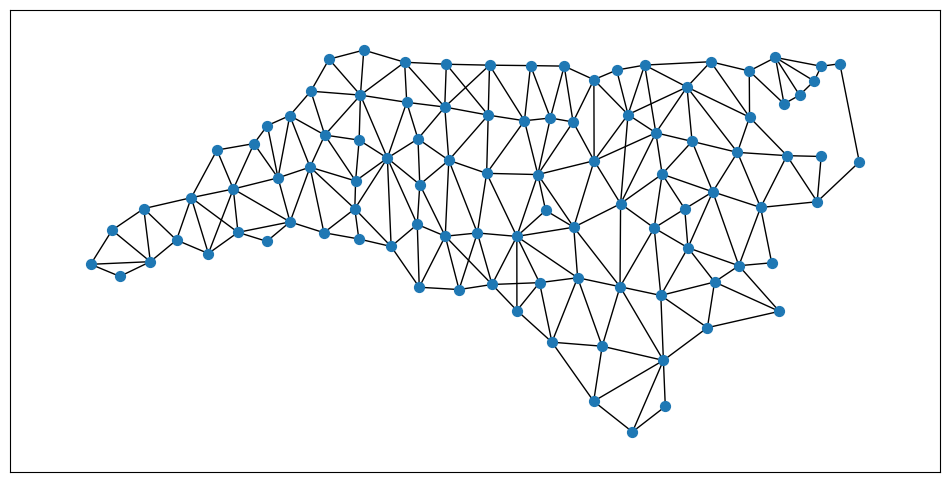

In [91]:
#build adjacencies on graph
G = nx.Graph()

#create nodes
for idx, county in gdf.iterrows():
    G.add_node(county["NAMELSAD"], geometry = county.geometry)

#create edges
for i, co1 in gdf.iterrows():
    for j, co2 in gdf.iterrows():
        if i<j and co1.geometry.touches(co2.geometry):
            G.add_edge(co1['NAMELSAD'], co2['NAMELSAD'])

#weights for edges based on similarity function
for co1, co2 in G.edges():
    G[co1][co2]['weight'] = similarity(co1,co2)


#position dictionary for graph
pos = {
    county['NAMELSAD']: (county.geometry.centroid.x, county.geometry.centroid.y) for _,county in gdf.iterrows()
}


#build graph
fig, ax = plt.subplots(figsize = (12,6))

nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50)

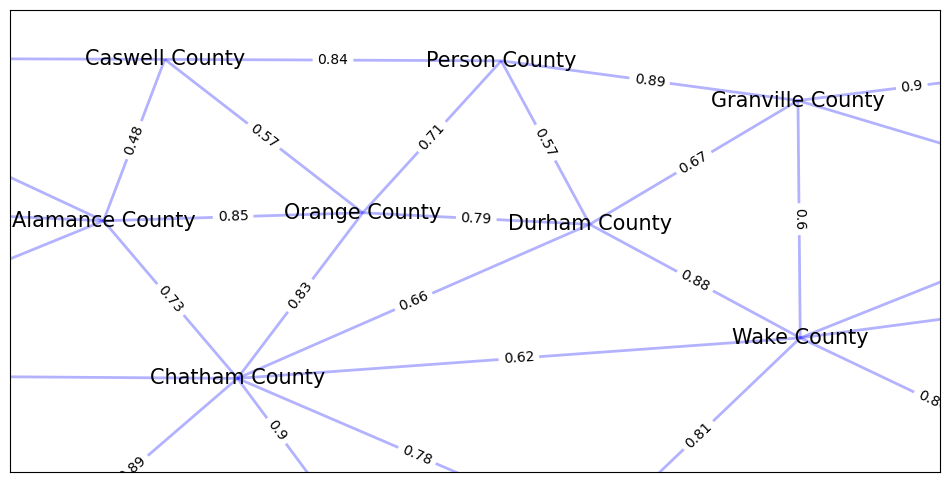

In [92]:
#demonstrated graph with weights
fig, ax = plt.subplots(figsize = (12,6))

#nx.draw_networkx_nodes(G, pos, ax = ax, node_size = 50)
nx.draw_networkx_edges(G, pos, ax = ax, width = 2, alpha = 0.3, edge_color = 'blue')
nx.draw_networkx_labels(G, pos, ax = ax, font_size = 15)

edge_weights = {edge: round(weight,2) for edge, weight in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_weights, ax = ax, font_size = 10)

plt.xlim(-79.5,-78.5)
plt.ylim(35.5,36.5)
plt.savefig('weights_example.png')
plt.show()

In [99]:
# adjacency matrix with weights
W = nx.to_numpy_array(G, weight='weight')

# Laplacian
D = np.diag(W.sum(axis=1))
L = D - W

# compute bottom-k eigenvectors (smallest eigenvalues)
k = 10
eigvals, eigvecs = np.linalg.eigh(L)
X = eigvecs[:, :k]

# Run k-means in spectral space
labels = KMeans(n_clusters=k, n_init='auto').fit_predict(X)

# attach labels to graph nodes
for node, label in zip(list(G.nodes),labels):
    G.nodes[node]['district'] = int(label)

C:\Users\olubl\anaconda3\envs\spatialdata\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


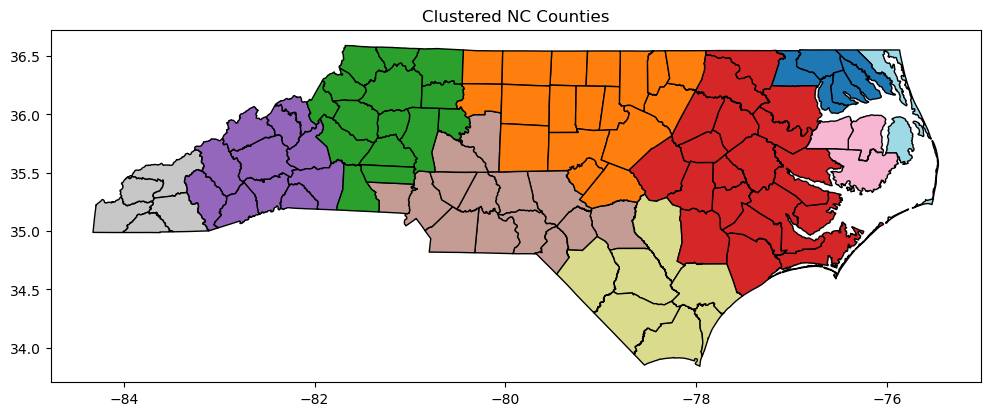

In [100]:
gdf_copy = gdf.copy()
gdf_copy["district"] = gdf_copy["NAMELSAD"].map(lambda x: G.nodes[x]["district"])

fig, ax = plt.subplots(figsize = (12,8))
gdf_copy.plot(column="district", cmap="tab20", ax = ax, legend=False, edgecolor="black")
plt.title("Clustered NC Counties")
plt.show()

In [93]:
edge_weights

{('Onslow County', 'Carteret County'): 0.75,
 ('Onslow County', 'Pender County'): 0.69,
 ('Onslow County', 'Jones County'): 0.29,
 ('Onslow County', 'Duplin County'): 0.7,
 ('Ashe County', 'Wilkes County'): 0.73,
 ('Ashe County', 'Alleghany County'): 0.78,
 ('Ashe County', 'Watauga County'): 0.79,
 ('Stokes County', 'Surry County'): 0.85,
 ('Stokes County', 'Rockingham County'): 0.79,
 ('Stokes County', 'Forsyth County'): 0.61,
 ('Stokes County', 'Guilford County'): 0.58,
 ('Currituck County', 'Dare County'): 0.89,
 ('Currituck County', 'Camden County'): 0.82,
 ('Swain County', 'Jackson County'): 0.66,
 ('Swain County', 'Macon County'): 0.68,
 ('Swain County', 'Haywood County'): 0.57,
 ('Swain County', 'Graham County'): 0.92,
 ('Northampton County', 'Hertford County'): 0.95,
 ('Northampton County', 'Bertie County'): 0.96,
 ('Northampton County', 'Halifax County'): 0.67,
 ('Northampton County', 'Warren County'): 0.96,
 ('Richmond County', 'Scotland County'): 0.89,
 ('Richmond County', '

In [96]:
W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
D

array([[2.4350478 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.30148858, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.8349367 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 4.98586881, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.15398875,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.87801435]])